# Question 2.5: GAN Distances

Initialize libraries

In [1]:
import math
import random
import os


from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Helper stuff

#### Insert other helpers

In [0]:
# ==
# From sampler


def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 2.3
    # USAGE:
    #     sampler = iter(samplers.distribution1(0))
    #     data = next(sampler)
    while True:
        yield(np.array([(x, random.uniform(0, 1), ) for _ in range(batch_size)]))



# ==
# From model



class Critic(nn.Module):
    # DONT MODIFY. Use this module for every questions of Q1. Your tests might fail if you modify this.
    def __init__(self, in_size=2):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_size, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, input):
        output = self.main(input)
        return output.squeeze()
        

#### Insert **Distance Functions**

In [0]:

def lp_reg(x, y, critic):
    """
    COMPLETE ME. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** The notation used for the parameters follow the one from Petzka et al: https://arxiv.org/pdf/1709.08894.pdf
    In other word, x are samples from the distribution mu and y are samples from the distribution nu. The critic is the
    equivalent of f in the paper. Also consider that the norm used is the L2 norm. This is important to consider,
    because we make the assumption that your implementation follows this notation when testing your function. ***

    :param x: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution P.
    :param y: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution Q.
    :param critic: (Module) - torch module that you want to regularize.
    :return: (FloatTensor) - shape: (1,) - Lipschitz penalty
    """

    # ==
    # Lipschitz penalty

    # Compute sample to use
    unif = torch.distributions.uniform.Uniform(0.0, 1.0)
    u = unif.sample()
    x_hat = (u * x) + ((1-u) * y)
    x_hat.requires_grad = True

    # Compute gradient of sample
    f_x = critic(x_hat)
    f_x_sum = torch.sum(f_x)
    f_x_sum.backward()

    # Gradient norm of x.grad, x.grad has shape (batch, feature)
    dx_norm = torch.norm(x_hat.grad, p=2, dim=1,
                         keepdim=False)  # (batch, )

    # Compute the per-element gradient penalty
    grad_penalty = torch.max(torch.zeros(dx_norm.size()),
                             (dx_norm - 1.0))  # (batch, )
    grad_penalty_sq = grad_penalty.pow(2)

    # Compute Lipschitz penalty
    lp = torch.mean(grad_penalty_sq)

    return lp


def vf_wasserstein_distance(x, y, critic):
    """
    COMPLETE ME. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** The notation used for the parameters follow the one from Petzka et al: https://arxiv.org/pdf/1709.08894.pdf
    In other word, x are samples from the distribution mu and y are samples from the distribution nu. The critic is the
    equivalent of f in the paper. This is important to consider, because we make the assuption that your implementation
    follows this notation when testing your function. ***

    :param p: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution p.
    :param q: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution q.
    :param critic: (Module) - torch module used to compute the Wasserstein distance
    :return: (FloatTensor) - shape: (1,) - Estimate of the Wasserstein distance
    """

    # ==
    # Wasserstein distance

    f_P = critic(x)  # real samples, (batch, )
    f_Q = critic(y)  # generated samples, (batch, )

    # Estimate empirical Wasserstein distance
    wd = torch.mean(f_P) - torch.mean(f_Q)

    return wd


def vf_squared_hellinger(x, y, critic):
    """
    Complete me. DONT MODIFY THE PARAMETERS OF THE FUNCTION. Otherwise, tests might fail.

    *** The notation used for the parameters follow the one from Nowazin et al: https://arxiv.org/pdf/1606.00709.pdf
    In other word, x are samples from the distribution P and y are samples from the distribution Q. Please note that the Critic is unbounded. ***

    :param p: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution p.
    :param q: (FloatTensor) - shape: (batchsize x featuresize) - Samples from a distribution q.
    :param critic: (Module) - torch module used to compute the Squared Hellinger.
    :return: (FloatTensor) - shape: (1,) - Estimate of the Squared Hellinger
    """

    # ==
    # Squared Hellinger objective

    # Compute V(x)'s
    v_P = critic(x)  # (batch, )
    v_Q = critic(y)  # (batch, )

    # Compute g(v)
    gv_P = 1.0 - (-v_P).exp()  # (batch, )
    gv_Q = 1.0 - (-v_Q).exp()  # (batch, )

    # Compute -f(g)
    neg_f = - ((gv_Q) / (1.0 - gv_Q))  # (batch, )

    # Empirical average Squared Hellinger loss
    sqh = torch.mean((gv_P + neg_f))

    return sqh

### Initialize stuff

Model and first distribution (P)

In [0]:
model = Critic(2)
optim = torch.optim.SGD(model.parameters(), lr=1e-3)

# Regularizaiton constant
lambda_reg_lp = 50  # Recommended hyper parameters for the lipschitz regularizer.

#### Evaluate distance

In [0]:
theta_list = []
sqhel_list = []
wassd_list = []

for theta in np.arange(0, 2.01, 0.1):
  # Samplers
  sampler1 = iter(distribution1(0, batch_size=512))
  sampler2 = iter(distribution1(theta, batch_size=512))

  # Get sample tensors
  x_P = torch.tensor(next(sampler1), dtype=torch.float,
                     requires_grad=False)
  y_Q = torch.tensor(next(sampler2), dtype=torch.float,
                      requires_grad=False)
  

  # ==
  # Evaluate Squared Hellinger distance
  cur_sh = vf_squared_hellinger(x_P, y_Q, model)

  # ==
  # Evaluate Earth-Mover distance
  cur_wd = vf_wasserstein_distance(x_P, y_Q, model)

  # Save
  theta_list.append(theta.item())
  sqhel_list.append(cur_sh.item())
  wassd_list.append(cur_wd.item())

### Visualize

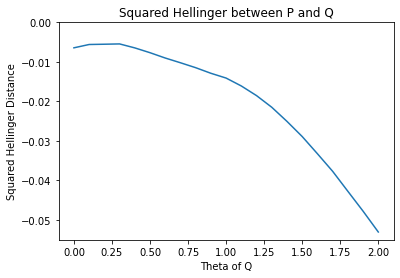

In [10]:
sns.lineplot(x=theta_list, y=sqhel_list)
plt.title('Squared Hellinger between P and Q')
plt.xlabel('Theta of Q')
plt.ylabel('Squared Hellinger Distance')
plt.ylim([-0.055, 0.0])
plt.show()

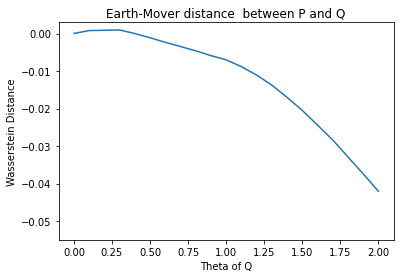

In [12]:
sns.lineplot(x=theta_list, y=wassd_list)
plt.title('Earth-Mover distance  between P and Q')
plt.xlabel('Theta of Q')
plt.ylabel('Wasserstein Distance')
plt.ylim([-0.055, 0.003])
plt.show()